# Homework - Introduction

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

## Downloading the data

The dataset used in this notebook is the [NYC taxi dataset](https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page). It contains records about taxi trips in New York like pickup times, trip distances and fares.

In [2]:
january = pd.read_parquet("../data/yellow_tripdata_2022-01.parquet")
february = pd.read_parquet("../data/yellow_tripdata_2022-02.parquet")

In [3]:
january.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,1,2022-01-01 00:35:40,2022-01-01 00:53:29,2.0,3.80,1.0,N,142,236,1,14.5,3.0,0.5,3.65,0.0,0.3,21.95,2.5,0.0
1,1,2022-01-01 00:33:43,2022-01-01 00:42:07,1.0,2.10,1.0,N,236,42,1,8.0,0.5,0.5,4.00,0.0,0.3,13.30,0.0,0.0
2,2,2022-01-01 00:53:21,2022-01-01 01:02:19,1.0,0.97,1.0,N,166,166,1,7.5,0.5,0.5,1.76,0.0,0.3,10.56,0.0,0.0
3,2,2022-01-01 00:25:21,2022-01-01 00:35:23,1.0,1.09,1.0,N,114,68,2,8.0,0.5,0.5,0.00,0.0,0.3,11.80,2.5,0.0
4,2,2022-01-01 00:36:48,2022-01-01 01:14:20,1.0,4.30,1.0,N,68,163,1,23.5,0.5,0.5,3.00,0.0,0.3,30.30,2.5,0.0


In [4]:
print(f"Rows: {january.shape[0]}\n"
      f"Columns: {january.shape[1]}")

Rows: 2463931
Columns: 19


## Computing duration

In [5]:
january["duration"] = january["tpep_dropoff_datetime"] - january["tpep_pickup_datetime"]
january["duration_seconds"] = january["duration"].apply(pd.Timedelta.total_seconds)
january["duration_minutes"] = january["duration_seconds"] / 60

In [6]:
print(f"Mean: {january.duration_minutes.mean():.2f}\n"
      f"Standard deviation: {january.duration_minutes.std():.2f}")

Mean: 14.21
Standard deviation: 46.45


## Droping outliers

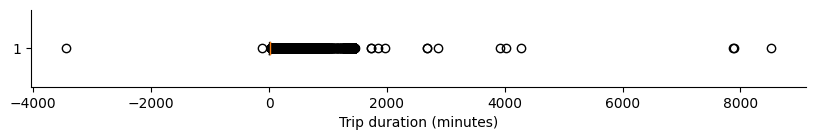

In [7]:
plt.figure(figsize=(10, 1))
plt.gca().spines[["top", "right"]].set_visible(False)
plt.boxplot(january["duration_minutes"], vert=False)
plt.xlabel("Trip duration (minutes)")
plt.show()

In [8]:
january_no_outliers = january[(january["duration_minutes"] >= 1) & (january["duration_minutes"] <= 60)]

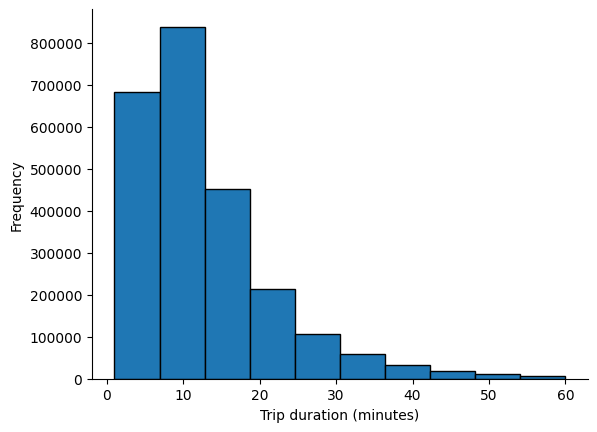

In [9]:
plt.hist(january_no_outliers["duration_minutes"], edgecolor="black")
plt.gca().spines[["top", "right"]].set_visible(False)
plt.ylabel("Frequency")
plt.xlabel("Trip duration (minutes)")
plt.show()

In [10]:
print(f"Records left after dropping outliers: {((january_no_outliers.shape[0] / january.shape[0]) * 100):.2f}%")

Records left after dropping outliers: 98.28%


## One-hot encoding

In [11]:
locations = ['PULocationID', 'DOLocationID']
january_no_outliers[locations] = january_no_outliers.copy()[locations].astype(str)
train = january_no_outliers[locations].to_dict(orient="records")

/tmp/ipykernel_6462/473747464.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  january_no_outliers[locations] = january_no_outliers.copy()[locations].astype(str)


In [12]:
dv = DictVectorizer()
X_train = dv.fit_transform(train)

In [13]:
print(f"Vectorizer feature matrix dimensionality: {len(dv.get_feature_names_out())}")

Vectorizer feature matrix dimensionality: 515


## Training a model

In [14]:
y_train = january_no_outliers["duration_minutes"]

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_train)

In [15]:
print(f"RMSE: {mean_squared_error(y_train, y_pred, squared=False):.2f}")

RMSE: 6.99


## Evaluating the model

In [16]:
february["duration"] = february["tpep_dropoff_datetime"] - february["tpep_pickup_datetime"]
february["duration_seconds"] = february["duration"].apply(pd.Timedelta.total_seconds)
february["duration_minutes"] = february["duration_seconds"] / 60

february_no_outliers = february[(february["duration_minutes"] >= 1) & (february["duration_minutes"] <= 60)]

february_no_outliers[locations] = february_no_outliers.copy()[locations].astype(str)
val = february_no_outliers[locations].to_dict(orient="records")

X_val = dv.transform(val) # Same vectorizer used in train dataset

/tmp/ipykernel_6462/2556753438.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  february_no_outliers[locations] = february_no_outliers.copy()[locations].astype(str)


In [17]:
y_val = february_no_outliers["duration_minutes"]

y_pred = model.predict(X_val)

print(f"RMSE: {mean_squared_error(y_val, y_pred, squared=False):.2f}")

RMSE: 7.79
